# Import libraries

In [3]:
import os
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler

# import shap
import optuna
# import category_encoders as ce
import optuna.visualization as vis

import xgboost as xgb
import catboost as cat
import lightgbm as lgb

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

# Get data

In [4]:
raw_train = pd.read_csv('data/train.csv')
raw_test = pd.read_csv('data/test.csv')
raw_sub = pd.read_csv('data/sample_submission.csv')

In [5]:
print(raw_train.info())
raw_train.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7007 entries, 0 to 7006
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Deal_title             7007 non-null   object 
 1   Lead_name              7007 non-null   object 
 2   Industry               7006 non-null   object 
 3   Deal_value             6956 non-null   object 
 4   Weighted_amount        6482 non-null   object 
 5   Date_of_creation       7007 non-null   object 
 6   Pitch                  7007 non-null   object 
 7   Contact_no             7007 non-null   object 
 8   Lead_revenue           7007 non-null   object 
 9   Fund_category          7007 non-null   object 
 10  Geography              6035 non-null   object 
 11  Location               6996 non-null   object 
 12  POC_name               6999 non-null   object 
 13  Designation            7007 non-null   object 
 14  Lead_POC_email         7007 non-null   object 
 15  Hiri

,Deal_title,Lead_name,Industry,Deal_value,Weighted_amount,Date_of_creation,Pitch,Contact_no,Lead_revenue,Fund_category,...,Designation,Lead_POC_email,Hiring_candidate_role,Lead_source,Level_of_meeting,Last_lead_update,Internal_POC,Resource,Internal_rating,Success_probability
2569,Title18LT0,"Zamora, Moore and Griffith LLC",Banks,89557$,497041.35$,2019-06-13,Product_2,(436)499-6570x554,50 - 100 Million,Category 2,...,Chairman/CEO/President,travisthompson@zamora.com,Quantity surveyor,Marketing Event,Level 1,More than a week back,"Thomas,Lori E",Yes,2,58.7


In [6]:
print(raw_test.info())
raw_test.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Deal_title             2093 non-null   object 
 1   Lead_name              2093 non-null   object 
 2   Industry               2092 non-null   object 
 3   Deal_value             2088 non-null   object 
 4   Weighted_amount        2033 non-null   object 
 5   Date_of_creation       2093 non-null   object 
 6   Pitch                  2093 non-null   object 
 7   Contact_no             2093 non-null   object 
 8   Lead_revenue           2093 non-null   object 
 9   Fund_category          2093 non-null   object 
 10  Geography              2014 non-null   object 
 11  Location               2090 non-null   object 
 12  POC_name               2091 non-null   object 
 13  Designation            2093 non-null   object 
 14  Lead_POC_email         2093 non-null   object 
 15  Hiri

,Deal_title,Lead_name,Industry,Deal_value,Weighted_amount,Date_of_creation,Pitch,Contact_no,Lead_revenue,Fund_category,...,POC_name,Designation,Lead_POC_email,Hiring_candidate_role,Lead_source,Level_of_meeting,Last_lead_update,Internal_POC,Resource,Internal_rating
1552,TitleWD36X,Christian-Jenkins Ltd,Health/Accident,29654$,189785.6$,2020-03-17,Product_2,784.396.5473x99463,50 - 100 Million,Category 3,...,Lauren Farmer,Executive Vice President,laurenfarmer@christianjenkins.com,Advice worker,Marketing Event,Level 3,Following up but lead not responding,"Gilley,Janine",Cannot deliver,3.0


# Preprocess

In [8]:
combine = raw_train.append(raw_test).reset_index(drop=True)

In [9]:
drop_cols = [
    'Deal_title', 'Lead_name', 'Contact_no', 'POC_name', 'Lead_POC_email',\
    'Industry', 'Date_of_creation', 'Designation', 'Resource',\
    'Hiring_candidate_role', 'Internal_POC', 'Lead_source', 'Last_lead_update',\
]
combine = combine.drop(drop_cols, axis=1)

In [10]:
combine['Weighted_amount'] = combine['Weighted_amount'].apply(lambda x: x if type(x) == float else float(x[:-1]))
combine['Deal_value'] = combine['Deal_value'].apply(lambda x: x if type(x) == float else float(x[:-1]))

combine['Deal_value'] = combine['Deal_value'].fillna(value=combine['Deal_value'].mean())
combine['Weighted_amount'] = combine['Weighted_amount'].fillna(value=combine['Weighted_amount'].mean())

In [11]:
mask = combine['Geography'].isna()
combine.loc[mask, 'Geography'] = combine.loc[mask, 'Location'].apply(lambda x: 'USA' if type(x) == float else 'USA' if ',' in x else 'India')

combine = combine.drop('Location', axis=1)

In [12]:
p = pd.get_dummies(combine['Pitch'], drop_first=True)
lr = pd.get_dummies(combine['Lead_revenue'], drop_first=True)
fc = pd.get_dummies(combine['Fund_category'], drop_first=True)
g = pd.get_dummies(combine['Geography'], drop_first=True)
lvl = pd.get_dummies(combine['Level_of_meeting'], drop_first=True)

In [13]:
combine = combine.drop(['Pitch', 'Lead_revenue', 'Fund_category', 'Geography', 'Level_of_meeting'], axis=1)

In [15]:
combine = pd.concat([combine, p, lr, fc, g, lvl], axis=1)
print(combine.info())
combine.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9100 entries, 0 to 9099
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Deal_value               9100 non-null   float64
 1   Weighted_amount          9100 non-null   float64
 2   Internal_rating          9100 non-null   float64
 3   Success_probability      7007 non-null   float64
 4   Product_2                9100 non-null   uint8  
 5   50 - 100 Million         9100 non-null   uint8  
 6   500 Million - 1 Billion  9100 non-null   uint8  
 7   Category 2               9100 non-null   uint8  
 8   Category 3               9100 non-null   uint8  
 9   Category 4               9100 non-null   uint8  
 10  USA                      9100 non-null   uint8  
 11  Level 2                  9100 non-null   uint8  
 12  Level 3                  9100 non-null   uint8  
dtypes: float64(4), uint8(9)
memory usage: 364.5 KB
None


,Deal_value,Weighted_amount,Internal_rating,Success_probability,Product_2,50 - 100 Million,500 Million - 1 Billion,Category 2,Category 3,Category 4,USA,Level 2,Level 3
7739,318946.0,1.865834e+06,4.0,NaN,1,1,0,0,1,0,0,1,0
8621,428962.0,2.595220e+06,2.0,NaN,1,0,0,1,0,0,0,0,1
6190,264911.0,1.721922e+06,3.0,26.35,0,0,1,0,0,1,0,0,0
144,365503.0,1.566788e+06,5.0,72.70,1,1,0,1,0,0,1,1,0
1756,228563.0,1.679938e+06,5.0,73.90,0,0,0,0,0,1,1,0,1


<AxesSubplot:>

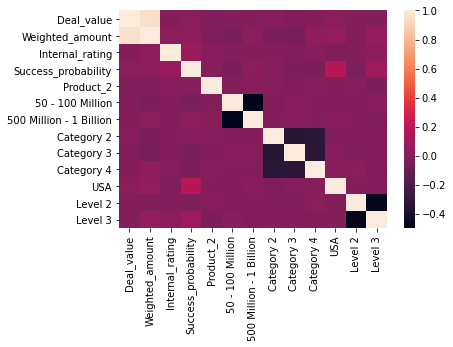

In [16]:
sns.heatmap(combine.corr())

In [56]:
mask = ~combine['Internal_rating'].between(0, 6)
combine.loc[mask, 'Internal_rating'] = 1

<AxesSubplot:>

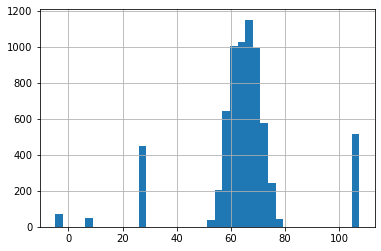

In [75]:
combine['Success_probability'].hist(bins=40)

In [20]:
mask = combine['Success_probability'].isna()
test = combine[mask].drop('Success_probability', axis=1)
train = combine[~mask]

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (7007, 13)
Test shape: (2093, 12)


In [21]:
X = train.drop('Success_probability', axis=1)
y = train['Success_probability']

# XGBoost

In [68]:
# change the objective

xgb_params = {
    # 'tree_method':'gpu_hist',
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'n_estimators': 100,
    'max_depth': 7,
    'learning_rate': 0.01,
#     'colsample_bytree': 0.3,
#     'reg_alpha': 10,
#     'gamma': 10,
#     'min_child_weight': 0.4,
#     'subsample': 0.9,
#     'colsample_bylevel': 0.4,
#     'colsample_bynode': 0.6,
#     'reg_lambda': 10,
#     'scale_pos_weight': 4,
#     'importance_type': 'gain',
#     'max_delta_step': ,
#     'base_score': ,
#     'tree_method': 'auto',
#     'missing': ,
#     'num_parallel_tree': ,
#     'monotone_constraints': ,
#     'interaction_constraints': ,
    'n_jobs': -1,
    'verbosity': 1,
}

In [69]:
def get_kfold_prediction(X, y, test_data, hyperparams, n_folds=5):
    scores = []
    oof_preds = np.zeros(test_data.shape[0])
    kf = KFold(n_splits=n_folds)

    for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

        train_x, valid_x = X.values[train_index], X.values[valid_index]
        train_y, valid_y = y[train_index], y[valid_index]

        #########################
        # Initialize model here #
        #########################
        model = xgb.XGBRegressor(**hyperparams)
        model.fit(train_x, train_y)

        preds = model.predict(valid_x)

        # change metric according to requirement
        score = np.sqrt(mean_squared_error(valid_y, preds))
        
        scores.append(score)

        # change this according to requirement
        oof_preds += model.predict(test_data.values) / n_folds

        print(f"Fold {fold + 1}: {score:.6f}")

    print(f'Mean Score: {np.mean(scores)}')
    
    return oof_preds

In [70]:
final_preds = get_kfold_prediction(X, y, test, xgb_params, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1: 29.978677
Fold 2: 29.885446
Fold 3: 28.858802
Fold 4: 29.107278
Fold 5: 29.260827
Fold 6: 29.556834
Fold 7: 29.446518
Fold 8: 30.097326
Fold 9: 28.754549
Fold 10: 29.647201
Mean Score: 29.459345712564847


In [71]:
sub = pd.DataFrame({
    'Deal_title': raw_test['Deal_title'], 'Success_probability': final_preds
})
print(sub.shape)
sub.head()

(2093, 2)


,Deal_title,Success_probability
0,TitleAD16O,36.762372
1,TitleOW6CR,41.362684
2,TitleVVJQ5,44.518299
3,TitleUS8NA,42.065948
4,Title5VGWW,43.843989


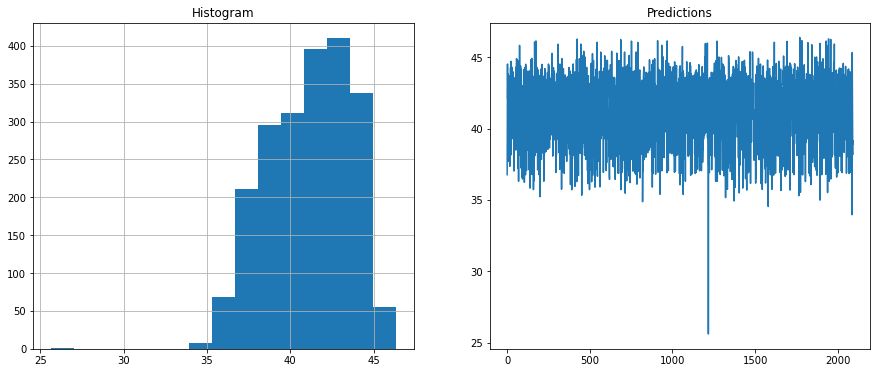

In [72]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
sub['Success_probability'].hist(ax=ax[0], bins=15)
sub['Success_probability'].plot(ax=ax[1])

ax[0].set_title('Histogram')
ax[1].set_title('Predictions')

plt.show()

In [73]:
sub.to_csv('submissions/xgb_3.csv', index=False)